In [1]:
!pip install flax

from functools import partial

from tqdm.auto import tqdm

import h5py
import numpy as np

import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt


# Make sure tf does not allocate gpu memory.
# tf.config.experimental.set_visible_devices([], "GPU")

# init rng seed
rng = jax.random.PRNGKey(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

--2022-11-17 12:46:23--  http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 128.100.89.2
Connecting to astro.utoronto.ca (astro.utoronto.ca)|128.100.89.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M) [text/plain]
Saving to: ‘Galaxy10.h5.2’

Galaxy10.h5.2       100%[===================>] 200.50M  29.3MB/s    in 8.5s    

2022-11-17 12:46:33 (23.6 MB/s) - ‘Galaxy10.h5.2’ saved [210234548/210234548]



In [3]:
# Get galaxies, ref.: https://astronn.readthedocs.io/en/latest/galaxy10sdss.html
with h5py.File('Galaxy10.h5', 'r') as F:
  labels = np.array(F['ans'])
  # reject some we don't care about, keep the rest
  (milkywaylikes_idx,) = np.where(labels > 3)
  images = np.array(F['images'][milkywaylikes_idx])
  # Milky way similar galaxies are class '3' ('-4' normalizes the labels again)
  labels = np.array(F['ans'][milkywaylikes_idx]) - 4

images = images.astype(np.float32) / 255.

# crop the image a bit to get 64x64 shape
def crop_center(images, cropx, cropy):
    _, y, x, _ = images.shape
    startx = x // 2 -(cropx // 2)
    starty = y // 2 -(cropy // 2)    
    return images[:, starty:starty+cropy, startx:startx+cropx, :]

images = crop_center(images=images, cropx=64, cropy=64)

# shuffle once
rng, key = jax.random.split(rng)
shuffle_idx = jax.random.randint(key, (len(images),), 0, len(images))
images = images[shuffle_idx, ...]
labels = labels[shuffle_idx, ...]

# show shape
print(images.shape)

(4686, 64, 64, 3)


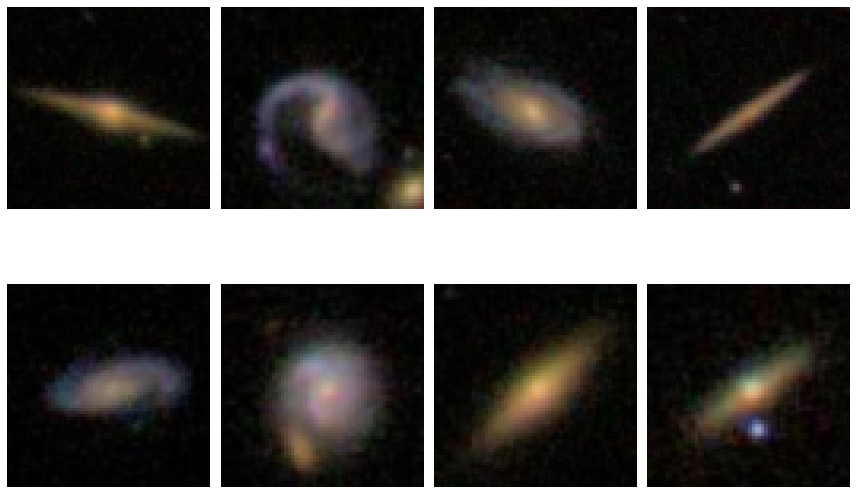

In [4]:
%matplotlib inline

def show_galaxies(images: np.ndarray) -> None:
  n = len(images)
  # always 4 in a column
  ncols = 4
  nrows = -(-n // ncols)
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

  for img, ax in zip(images, axes.ravel()):
    ax.imshow(img)
    ax.axis('off')
    fig.tight_layout()

# plot first 8 images
show_galaxies(images[:8])

## Task

Find a galaxy which looks as close as possible to our milky way!

**Bonus**: Generate a new galaxy, which looks as close as possible to our milky way.

#### Milky way

![Milky way](https://solarsystem.nasa.gov/system/resources/detail_files/285_ssc2008-10b1.jpg)